In [ ]:
%%capture
!pip install lazypredict
!pip install plotly_express
!pip install category_encoders

In [ ]:
# Libreria y funciones usadas para el pproyecto

from pandas import DataFrame, read_csv, set_option, to_pickle, read_pickle
set_option('display.max_rows', None)
set_option('display.max_columns', None)
from numpy import concatenate, zeros, nan, sqrt
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import CountEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split             # Dividir dataset en datos de entrenamiento y de prueba para el modelado
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import r2_score                            # Importante para evaluar regresion.
from sklearn.metrics import mean_squared_error                  # Me sirve tambien para sacar el RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from joblib import dump, load
from google.colab import files

In [ ]:
# Subir el archivo Pickle
uploaded = files.upload()

# Cargar el DataFrame desde el archivo Pickle
df_google_sin_duplicados = read_pickle('df_google_sin_duplicados.pkl')

Saving df_google_sin_duplicados.pkl to df_google_sin_duplicados.pkl


## Preprocesado de datos

In [ ]:
# Separo mi target de mi data y creo listas con variables categoricas y numericas

y = df_google_sin_duplicados[['Rating']]
x = df_google_sin_duplicados.drop(columns="Rating", axis=1)

numeric_cols= x.select_dtypes(include=["float64","int64"])  # Excluye la columna Rating
categorical_cols = x.select_dtypes(include="object")

numerical_list = numeric_cols.columns.tolist()              # Excluye a Rating
categorical_list = categorical_cols.columns.tolist()

random_state = 42

x.head()

,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,159.00,19000.00,10000.00,Free,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,967.00,14000.00,500000.00,Free,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,87510.00,8700.00,2498500.00,Free,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,115962.25,25000.00,2498500.00,Free,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,967.00,2800.00,100000.00,Free,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
# Las numericas las escalare con StandardScaler()

numeric_cols.head()

,Reviews,Size,Installs
0,159.00,19000.00,10000.00
1,967.00,14000.00,500000.00
2,87510.00,8700.00,2498500.00
3,115962.25,25000.00,2498500.00
4,967.00,2800.00,100000.00


In [ ]:
# Las categoricas las codificare con TargetEncoder()

categorical_cols.head()

,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Free,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Free,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,Free,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Free,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Free,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
# Defino mis x_train, x_test, y_train, y y_test:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state = random_state, shuffle=True) # 0,33 optimiza mi r2


In [ ]:
# Escaladores.

object_scaler= TargetEncoder(cols=categorical_cols)

numerical_scaler = StandardScaler()


In [ ]:
# Divido mis datos en numericos y categoricos
x_train_num = x_train.select_dtypes(include=["float64","int64"])
x_test_num = x_test.select_dtypes(include=["float64","int64"])
x_train_obj = x_train.select_dtypes(include=["object"])
x_test_obj = x_test.select_dtypes(include=["object"])

In [ ]:
# Escalo mis datos.
# Primero los de train

x_train_num_transformed = numerical_scaler.fit_transform(x_train_num, y_train)
x_train_obj_transformed = object_scaler.fit_transform(x_train_obj, y_train)

# Segundo escalo los de test.

x_test_num_transformed = numerical_scaler.transform(x_test_num)
x_test_obj_transformed = object_scaler.transform(x_test_obj)

# Tercero junto los datos escalados transformandolos a df y diferenciando por train y test
x_test_transformed = concatenate((x_test_num_transformed, x_test_obj_transformed), axis = 1)
x_test_transformed

array([[-0.64908979,  0.20471341, -0.76498907, ...,  4.21933612,
         4.19867225,  4.1747541 ],
       [-0.65254454, -0.93817464, -0.76986853, ...,  4.1937285 ,
         4.18340629,  4.17454545],
       [-0.60989851,  0.26550533, -0.67715876, ...,  4.21571316,
         4.23507738,  4.1747541 ],
       ...,
       [-0.60047645,  0.44788109,  0.20114429, ...,  4.38473683,
         4.19867225,  4.2437751 ],
       [-0.6562012 , -0.62813586, -0.7746504 , ...,  4.13243046,
         4.13299619,  4.24258065],
       [-0.6562685 ,  0.10018371, -0.7737721 , ...,  4.1275031 ,
         4.26791809,  4.27303507]])

In [ ]:
x_test_transformed.shape # Para comprobar que las dimenciones estan correctas

In [ ]:
df_x_test_transformed =DataFrame(x_test_transformed, columns = ["Reviews", "Size", "Installs", 'Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'])
df_x_test_transformed.head()

,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,-0.65,0.20,-0.76,4.19,4.19,4.15,4.22,4.20,4.17
1,-0.65,-0.94,-0.77,4.19,4.19,4.12,4.19,4.18,4.17
2,-0.61,0.27,-0.68,4.19,4.13,3.99,4.22,4.24,4.17
3,1.95,0.10,1.66,4.19,4.19,4.08,4.33,4.27,4.27
4,1.25,1.60,0.20,4.19,4.25,4.22,4.29,4.20,4.17


In [ ]:
x_train_transformed = concatenate((x_train_num_transformed, x_train_obj_transformed), axis = 1)
x_train_transformed

array([[ 1.94516774,  0.02233766,  1.66351887, ...,  4.26934022,
         4.2272308 ,  4.24258065],
       [-0.63706545, -1.01720414, -0.76986853, ...,  4.24105735,
         4.21753372,  4.18866433],
       [ 1.94516774,  0.10018371,  1.66351887, ...,  4.24042062,
         4.26791809,  4.27303507],
       ...,
       [-0.65608903, -1.1205504 , -0.77473823, ...,  4.22979033,
         4.21753372,  4.2437751 ],
       [-0.07100157,  0.10018371,  1.66351887, ...,  4.32555554,
         4.12963165,  4.27303507],
       [-0.6562685 , -0.5247896 , -0.77473823, ...,  4.17402985,
         4.08303105,  4.24258065]])

In [ ]:
x_train_transformed.shape

In [ ]:
df_x_train_transformed =DataFrame(x_train_transformed, columns = ["Reviews", "Size", "Installs", 'Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'])
df_x_train_transformed.head()

,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,1.95,0.02,1.66,4.19,4.19,4.15,4.27,4.23,4.24
1,-0.64,-1.02,-0.77,4.19,4.19,4.12,4.24,4.22,4.19
2,1.95,0.10,1.66,4.19,4.19,4.23,4.24,4.27,4.27
3,-0.64,-0.83,-0.68,4.19,4.19,4.35,4.22,4.15,4.24
4,-0.66,-0.16,-0.77,4.26,4.13,3.99,4.19,4.10,4.17


In [ ]:
# Voy a resetear los indices para trabajar con las tablas mas adelante

df_x_train_transformed = df_x_train_transformed.copy().reset_index(drop=True)
df_x_train_transformed.head()

,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,1.95,0.02,1.66,4.19,4.19,4.15,4.27,4.23,4.24
1,-0.64,-1.02,-0.77,4.19,4.19,4.12,4.24,4.22,4.19
2,1.95,0.10,1.66,4.19,4.19,4.23,4.24,4.27,4.27
3,-0.64,-0.83,-0.68,4.19,4.19,4.35,4.22,4.15,4.24
4,-0.66,-0.16,-0.77,4.26,4.13,3.99,4.19,4.10,4.17


In [ ]:
df_x_test_transformed = df_x_test_transformed.copy().reset_index(drop=True)
df_x_test_transformed.head()

,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,-0.65,0.20,-0.76,4.19,4.19,4.15,4.22,4.20,4.17
1,-0.65,-0.94,-0.77,4.19,4.19,4.12,4.19,4.18,4.17
2,-0.61,0.27,-0.68,4.19,4.13,3.99,4.22,4.24,4.17
3,1.95,0.10,1.66,4.19,4.19,4.08,4.33,4.27,4.27
4,1.25,1.60,0.20,4.19,4.25,4.22,4.29,4.20,4.17


In [ ]:
y_test = y_test.copy().reset_index(drop=True)
y_test.head()

,Rating
0,2.90
1,4.60
2,4.10
3,4.30
4,4.50


In [ ]:
y_train = y_train.copy().reset_index(drop=True)
y_train.head()

,Rating
0,4.40
1,4.60
2,4.50
3,4.40
4,3.50


In [ ]:
# Guardar el DataFrame en un archivo Pickle
df_x_train_transformed.to_pickle('df_x_train_transformed.pkl')
# Descargar el archivo Pickle
from google.colab import files
files.download('df_x_train_transformed.pkl')

# Guardar el DataFrame en un archivo Pickle
df_x_test_transformed.to_pickle('df_x_test_transformed.pkl')
# Descargar el archivo Pickle
from google.colab import files
files.download('df_x_test_transformed.pkl')

# Guardar el DataFrame en un archivo Pickle
y_train.to_pickle('y_train.pkl')
# Descargar el archivo Pickle
from google.colab import files
files.download('y_train.pkl')

# Guardar el DataFrame en un archivo Pickle
y_test.to_pickle('y_test.pkl')
# Descargar el archivo Pickle
from google.colab import files
files.download('y_test.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Mis regresores elegidos son los siguientes

regressor_linear = LinearRegression()  # Regresor de prueba para comparar rendimientos.
regressor_boosting = GradientBoostingRegressor(random_state=42)  # Regresor de arboles de ensamble basado en boosting

In [ ]:
model_linear = regressor_linear.fit(df_x_train_transformed,y_train)  # Ajusto con los datos de entrenamiento

model_boosting = regressor_boosting.fit(df_x_train_transformed,y_train)

In [ ]:
test_score_linear = model_linear.score(df_x_test_transformed, y_test)
print(test_score_linear)

train_score_linear = model_linear.score(df_x_train_transformed, y_train)
print(train_score_linear)

-0.07527995674998467
0.29675606640737695


In [ ]:
test_score_boosting = model_boosting.score(df_x_test_transformed, y_test)
print(test_score_boosting)

train_score_boosting = model_boosting.score(df_x_train_transformed, y_train)
print(train_score_boosting)

-0.06225921976012949
0.5126581973044289


In [ ]:
y_prediction_linear = model_linear.predict(df_x_test_transformed)

In [ ]:
df_y_prediction_linear= DataFrame(y_prediction_linear)

df_y_prediction_linear = df_y_prediction_linear.rename(columns={0:"Predicción Rating Modelo Lineal"})

df_y_prediction_linear.head()

,Predicción Rating Modelo Lineal
0,4.15
1,4.04
2,4.10
3,4.53
4,4.42


In [ ]:
# prediccion

y_prediction_boosting = model_boosting.predict(df_x_test_transformed)

In [ ]:
df_y_prediction_boosting= DataFrame(y_prediction_boosting)

df_y_prediction_boosting = df_y_prediction_boosting.rename(columns={0:"Predicción Rating Boosting"})

df_y_prediction_boosting.head()

,Predicción Rating Boosting
0,4.12
1,4.06
2,4.25
3,4.35
4,4.28


In [ ]:
# Probando las predicciones

print(df_y_prediction_linear.loc[90])
print(df_y_prediction_boosting.loc[90])
print(y_test.loc[90])

Predicción Rating Modelo Lineal   3.99
Name: 90, dtype: float64
Predicción Rating Boosting   4.07
Name: 90, dtype: float64
Rating   4.30
Name: 90, dtype: float64


In [ ]:
# Saco metricas

#r2
print(f"R2 del modelo lineal corresponde a: {round(r2_score(y_test,df_y_prediction_linear), 4)}")
print(f"R2 del modelo de boosting corresponde a: {round(r2_score(y_test,df_y_prediction_boosting), 4)}")
print("                                                                                            ")

#RMSE

print(f"RMSE del modelo lineal corresponde a: {round(mean_squared_error(y_test,df_y_prediction_linear, squared=False), 4)}")   # Lo saco para ver los datos de uns forma más cercana a como nosotros tenemos nuestros datos
print(f"RMSE del modelo de boosting corresponde a: {round(mean_squared_error(y_test,df_y_prediction_boosting, squared=False), 4)}")  # Corresponde a la raiz cuadrada del MSE
print("                                                                                            ")

#MSE

print(f"MSE del modelo lineal corresponde a: {round(mean_squared_error(y_test,y_prediction_linear), 4)}")
print(f"MSE del modelo de boosting corresponde a: {round(mean_squared_error(y_test,y_prediction_boosting), 4)}")
print("                                                                                            ")

# MAE

print(f"MAE del modelo lineal corresponde a: {round(mean_absolute_error(y_test,y_prediction_linear), 4)}")
print(f"MAE del modelo de boosting corresponde a: {round(mean_absolute_error(y_test,y_prediction_boosting), 4)}")

R2 del modelo lineal corresponde a: -0.0753
R2 del modelo de boosting corresponde a: -0.0623
                                                                                            
RMSE del modelo lineal corresponde a: 0.5065
RMSE del modelo de boosting corresponde a: 0.5034
                                                                                            
MSE del modelo lineal corresponde a: 0.2566
MSE del modelo de boosting corresponde a: 0.2534
                                                                                            
MAE del modelo lineal corresponde a: 0.3484
MAE del modelo de boosting corresponde a: 0.3298


Las metricas son bastante similares, lo cual me indica que no hay mayor diferencia entre elegir entre un modelo u otro. Considerando que hay que tratar de hacer el modelo lo más liviano y simple posible, eligire el LinearRegressor.

Hay que destacar en las metricas que el r2 es muy malo. Esto me puede llevar a descartar el modelo o seguir intentando con convinaciones de otras variables o sacando algunas y poniendo otras. Tambien agrandar el numero de muestras del dataset puede ser util, ya que un modelo con mayor información predice de mejor manera, especialmente en los de regresión que se basan en información historica.

Si nos vamos a ver el MSE y el MAE estos nos dan mejores resultados, ya que mi variable objetivo es una variable continua que se mueve entre el 1 y 5. Un puntaje de 4.5 real vs 4.3 o 4.2 predicho no me cambia mucho el scenario al decidir si una app es buena o mala. En ambos casos yo concluiria que es buena.

Entonces considerando esas 3 metricas podemos decir que quizas falta mejorar aun el dataset, y si los score siguen bajos se tendrá que descartar el modelo.

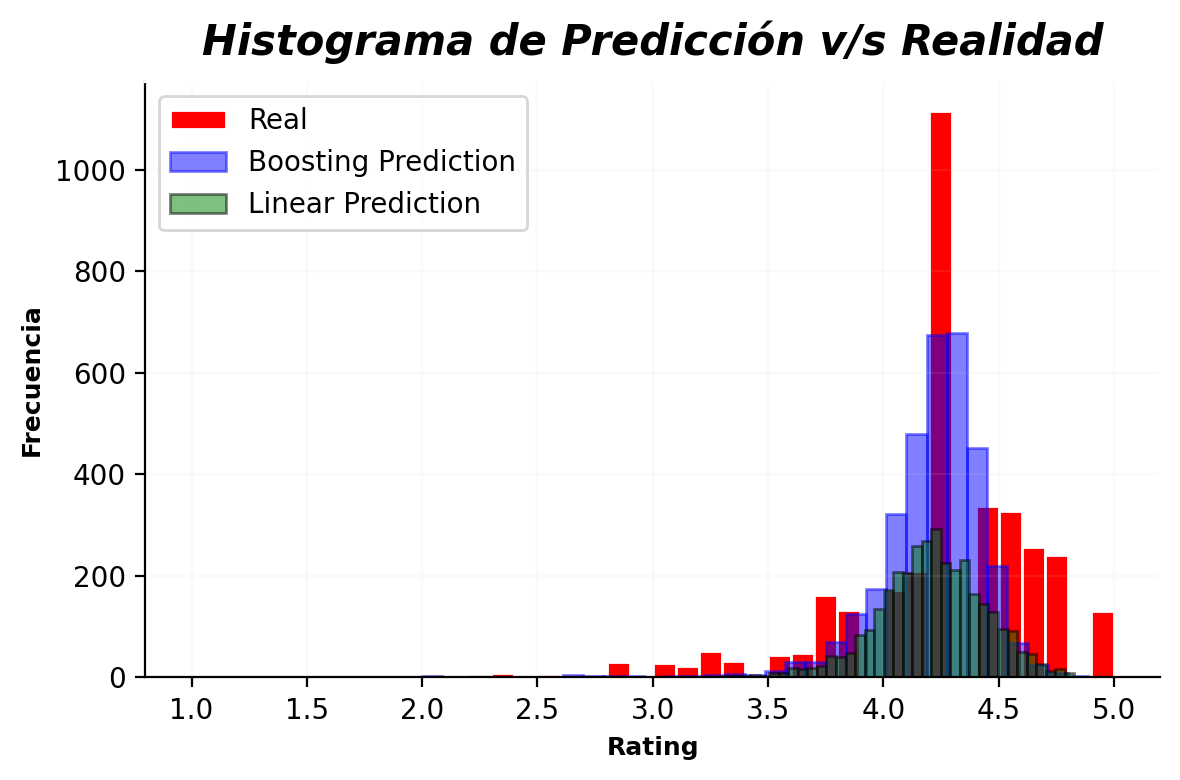

In [ ]:
# Voy a realizar un gráfico de histograma con el Y real y los Y predichos para comparar cuan certera es la predicción.

plt.figure(figsize=(6,4), dpi=200)
plt.hist(y_test, bins=40, alpha= 1, zorder=1, color="red", label="Real", ec= "white")
plt.hist(df_y_prediction_boosting, alpha= 0.5, zorder= 1, bins=40, color="blue", ec= "blue", label="Boosting Prediction")
plt.hist(df_y_prediction_linear, alpha= 0.5, zorder= 1, bins=40, color="green", ec= "black", label="Linear Prediction")


plt.xlabel("Rating", fontsize=9, fontweight="bold")
plt.ylabel("Frecuencia", fontsize=9,  fontweight="bold")


plt.title("Histograma de Predicción v/s Realidad", pad= 10, fontweight="bold", fontstyle="italic", fontsize=15)
plt.legend(loc="best")

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color("black")
plt.gca().spines['right'].set_color('white')
plt.gca().spines['top'].set_color("white")

plt.grid(color="lightgrey", alpha=0.1, zorder=0.3)

plt.tight_layout()

plt.show()

In [ ]:
# Voy a realizar un diccionario para generar un df que guarde y compare los Y reales con los predichos en base a los correspondientes reales.

data_dicc={"Real":list(y_test.values), "Predicho Boosting": list(df_y_prediction_boosting.values), "Predicho Lineal": list(df_y_prediction_linear.values)}
data_dicc

# Creo mi DF

real_prediction= DataFrame(data_dicc)

real_prediction['Real'] = real_prediction['Real'].astype(float)
real_prediction['Predicho Boosting'] = real_prediction['Predicho Boosting'].astype(float)
real_prediction['Predicho Lineal'] = real_prediction['Predicho Lineal'].astype(float)

real_prediction.head(50)

,Real,Predicho Boosting,Predicho Lineal
0,2.90,4.12,4.15
1,4.60,4.06,4.04
2,4.10,4.25,4.10
3,4.30,4.35,4.53
4,4.50,4.28,4.42
5,4.40,4.04,4.23
6,3.60,4.39,4.60
7,4.60,4.29,4.23
8,5.00,3.90,4.00
9,4.40,3.01,3.71


In [ ]:
# Voy a realizar un gráfico para ver la forma de mi función como curva. Probablemente esta no tenga mucho sentido, pero es para visualisarla mejor.

#Gráfico Realidad versus Predicción

# Crear gráfico de línea con Plotly Express
fig = px.line(x=range(len(real_prediction)),                                       # Eje X corresponde al número de datos
              y=[real_prediction['Real'], real_prediction['Predicho Boosting']],            # Fijo los valores de Y_real y Y_predicho
              labels={"y": "Rating", "x": "Datos del Modelo"},  # Asigno nombre a los ejes
              title="Predicción Boosting v/s Realidad",
              color_discrete_map={"Real": "green", "Predicho": "#EEA6FB"}          # Establecer colores para cada serie
              )

# Personalizar el diseño
fig.update_layout(title=dict(font=dict(size=30, color="blue", family="Arial"),
                             pad=dict(b=15, l=0, r=0, t=15), x=0.5),               # Espacio y centrado del titulo
                  xaxis=dict(title=dict(text="Datos del Modelo", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  yaxis=dict(title=dict(text="Rating", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  paper_bgcolor="white",
                  plot_bgcolor="white")

# Actualizar colores y leyenda
color_map = {"wide_variable_0": "green", "wide_variable_1": "#EEA6FB"}       # Asigno colores a la leyenda para que calcen con los de las lineas del px.line
for i, trace in enumerate(fig.data):
    trace.line.color = color_map.get(trace.name, "blue")                     # "blue" será el color predeterminado si el nombre no se encuentra en el mapa

# Cambiar nombres en la leyenda
fig.for_each_trace(lambda trace: trace.update(name="Real" if "wide_variable_0" in trace.name else "Predicho Boosting"))   # Con .update() estoy actualizando el nombre

# Mostrar el gráfico
fig.show()

In [ ]:
# Voy a realizar un gráfico para ver la forma de mi función como curva. Probablemente esta no tenga mucho sentido, pero es para visualisarla mejor.

#Gráfico Realidad versus Predicción

# Crear gráfico de línea con Plotly Express
fig = px.line(x=range(len(real_prediction)),                                       # Eje X corresponde al número de datos
              y=[real_prediction['Real'], real_prediction['Predicho Lineal']],            # Fijo los valores de Y_real y Y_predicho
              labels={"y": "Rating", "x": "Datos del Modelo"},  # Asigno nombre a los ejes
              title="Predicción Lineal v/s Realidad",
              color_discrete_map={"Real": "green", "Predicho": "#EEA6FB"}          # Establecer colores para cada serie
              )

# Personalizar el diseño
fig.update_layout(title=dict(font=dict(size=30, color="blue", family="Arial"),
                             pad=dict(b=15, l=0, r=0, t=15), x=0.5),               # Espacio y centrado del titulo
                  xaxis=dict(title=dict(text="Datos del Modelo", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  yaxis=dict(title=dict(text="Rating", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  paper_bgcolor="white",
                  plot_bgcolor="white")

# Actualizar colores y leyenda
color_map = {"wide_variable_0": "green", "wide_variable_1": "#EEA6FB"}       # Asigno colores a la leyenda para que calcen con los de las lineas del px.line
for i, trace in enumerate(fig.data):
    trace.line.color = color_map.get(trace.name, "blue")                     # "blue" será el color predeterminado si el nombre no se encuentra en el mapa

# Cambiar nombres en la leyenda
fig.for_each_trace(lambda trace: trace.update(name="Real" if "wide_variable_0" in trace.name else "Predicho Lineal"))   # Con .update() estoy actualizando el nombre

# Mostrar el gráfico
fig.show()

En estos graficos realizados con plotly se puede apreciar como el modelo lineal abarca menos pero al mismo tiempo se ajusta más a los valores reales.